- ISSUE: processing too much data at once, kernal crashes or runs forever. need a different way to calculate
- d/dx --> east - west, d/dy --> north - south

In [1]:
import numpy as np
import os
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import dask
from dask import delayed, compute

In [6]:
# Base path where the folders are located
base_path = '/data/rong4/Data/ERA5/3hourly/quvw_US'

# Define the range of years and months
years = [str(year) for year in range(2001, 2020)]
months = ['05', '06', '07', '08', '09']

# Function to filter files by year and month
def get_files(folder, component):
    # Use glob to find files matching the component pattern
    files = glob.glob(os.path.join(base_path, folder, f"era5.{component}.*.nc"))
    # Filter files by years and months
    filtered_files = [f for f in files if any(year in f for year in years) and any(f".{year}{month}" in f for year in years for month in months)]
    return filtered_files

# Get the files for each component
u_files = get_files('u_component_of_wind', 'u_component_of_wind')
v_files = get_files('v_component_of_wind', 'v_component_of_wind')
q_files = get_files('specific_humidity', 'specific_humidity')

all_files = u_files + v_files + q_files

# # Open all datasets at once
# era5 = xr.open_mfdataset(all_files, combine='by_coords')

# Specify chunk sizes for each dimension
chunk_sizes = {'time': 100, 'level': 29, 'latitude': 50, 'longitude': 50}

# Open the dataset with chunking applied
era5 = xr.open_mfdataset(all_files, combine='by_coords', chunks=chunk_sizes)

# Converting to central time
era5['time'] = era5['time'] - pd.Timedelta(hours=6)

In [7]:
def moisture_budget_profiles(u, v, q, lat, lon):

    R = 6371000  # Radius of Earth (meters)
    
    lon_grid, lat_grid = np.meshgrid(np.radians(lon), np.radians(lat))
    grid_dist = np.radians(lat[1]) - np.radians(lat[0])
    
    cos_correction = R * np.cos(lat_grid)
    dy_cos_correction = cos_correction / R
    
    # Initialize 3D arrays for derivatives
    dudx = np.zeros_like(u)
    dvdy = np.zeros_like(v)
    dqdx = np.zeros_like(q)
    dqdy = np.zeros_like(q)
    
    # Loop through each pressure level
    for k in range(u.shape[0]):  # Loop over pressure levels
        v_dy = v[k] * dy_cos_correction
        q_dy = q[k] * dy_cos_correction

        # Central differences for interior points
        dudx[k, :, 1:-1] = (u[k, :, 2:] - u[k, :, :-2]) / (2 * grid_dist)
        dvdy[k, 1:-1, :] = (v_dy[2:, :] - v_dy[:-2, :]) / (2 * grid_dist)
        dqdx[k, :, 1:-1] = (q[k, :, 2:] - q[k, :, :-2]) / (2 * grid_dist)
        dqdy[k, 1:-1, :] = (q_dy[2:, :] - q_dy[:-2, :]) / (2 * grid_dist)

        # Boundary points (one-sided differences)
        # Left and right boundaries (x-direction)
        dudx[k, :, 0] = (u[k, :, 1] - u[k, :, 0]) / grid_dist  # forward difference
        dudx[k, :, -1] = (u[k, :, -1] - u[k, :, -2]) / grid_dist  # backward difference
        
        dqdx[k, :, 0] = (q[k, :, 1] - q[k, :, 0]) / grid_dist
        dqdx[k, :, -1] = (q[k, :, -1] - q[k, :, -2]) / grid_dist

        # Top and bottom boundaries (y-direction)
        dvdy[k, 0, :] = (v_dy[1, :] - v_dy[0, :]) / grid_dist  # forward difference
        dvdy[k, -1, :] = (v_dy[-1, :] - v_dy[-2, :]) / grid_dist  # backward difference
        
        dqdy[k, 0, :] = (q_dy[1, :] - q_dy[0, :]) / grid_dist
        dqdy[k, -1, :] = (q_dy[-1, :] - q_dy[-2, :]) / grid_dist

        # Apply cos_correction for spherical coordinates
        dudx[k] = (1 / cos_correction) * dudx[k]
        dvdy[k] = (1 / cos_correction) * dvdy[k]
        dqdy[k] = (1 / cos_correction) * dqdy[k]
        dqdx[k] = (1 / cos_correction) * dqdx[k]

    # Moisture advection for each pressure level
    moisture_advection = u * dqdx + v * dqdy

    # Dynamical convergence for each pressure level
    dynamical_convergence = q * dudx + q * dvdy

    # Total moisture flux convergence
    mfc = dynamical_convergence + moisture_advection

    # Units --> 1/s
    return mfc, dynamical_convergence, moisture_advection

In [11]:
pressure_levels = era5['level'].data * 100  # Pascals
latsgp = era5['latitude'].data[::-1]  # degrees, reversing in order for code to run correctly
lonsgp = era5['longitude'].data  # degrees

# Function to process a single time step without using `.load()`
def process_single_time_step(time_index, u, v, q):
    # Extract the data lazily; no need to load it all at once
    u_data = u.isel(time=time_index).data[:, ::-1, :]
    v_data = v.isel(time=time_index).data[:, ::-1, :]
    q_data = q.isel(time=time_index).data[:, ::-1, :]

    # Call the moisture_budget_profiles function (no need to pass latsgp/lonsgp here)
    mfc, dyn_conv, moist_adv = moisture_budget_profiles(u_data, v_data, q_data, latsgp, lonsgp)

    return mfc, dyn_conv, moist_adv

# Number of time steps
num_times = era5['time'].size

# Create delayed tasks for each time step
results = []
for time_index in range(num_times):
    result = process_single_time_step(time_index, era5['u'], era5['v'], era5['q'])
    results.append(result)

# Use Dask to compute everything in parallel
delayed_results = compute(*results)

# Unzip the results into individual components
mfc_list, dyn_conv_list, moist_adv_list = zip(*delayed_results)

# Stack the results along the time dimension
mfc_profiles = da.stack(mfc_list, axis=0)
dyn_conv_profiles = da.stack(dyn_conv_list, axis=0)
moist_adv_profiles = da.stack(moist_adv_list, axis=0)

# Create xarray Datasets from the final stacked Dask arrays
ds = xr.Dataset(
    {
        'moisture_flux_convergence': (['time', 'level', 'latitude', 'longitude'], mfc_profiles),
        'dynamic_convergence': (['time', 'level', 'latitude', 'longitude'], dyn_conv_profiles),
        'moisture_advection': (['time', 'level', 'latitude', 'longitude'], moist_adv_profiles),
    },
    coords={
        'time': era5['time'],
        'level': era5['level'],
        'latitude': latsgp,
        'longitude': lonsgp
    }
)


KeyboardInterrupt: 

In [194]:
# Filtering for a specific time of day to capture clearer signal
hours_to_keep = [15]
mask = mfc_da['time'].dt.hour.isin(hours_to_keep)

# Subset the dataset using the mask with drop=True
mfc_da_morning = mfc_da.sel(time=mask, drop=True)
dyn_conv_da_morning = dyn_conv_da.sel(time=mask, drop=True)
moist_adv_da_morning = moist_adv_da.sel(time=mask, drop=True)

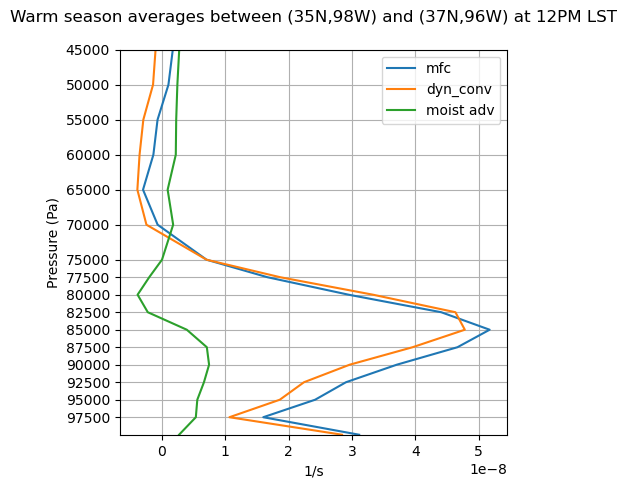

In [195]:
# What is the average warm-season profile in this domain?

plt.figure(figsize=(5, 5))

mfc_mean_profile = np.mean(mfc_da_morning.data,axis=(0,2,3))
dyn_conv_mean_profile = np.mean(dyn_conv_da_morning.data,axis=(0,2,3))
moist_adv_mean_profile = np.mean(moist_adv_da_morning.data,axis=(0,2,3))

plt.plot(mfc_mean_profile, pressure_levels, label='mfc')
plt.plot(dyn_conv_mean_profile, pressure_levels, label='dyn_conv')
plt.plot(moist_adv_mean_profile, pressure_levels, label='moist adv')
plt.gca().invert_yaxis()
plt.ylim(pressure_levels[-1],pressure_levels[-17])
# plt.fill_betweenx(pressure_levels, x1=np.min(mfc_mean_profile), x2=np.max(mfc_mean_profile), where=(pressure_levels <= 95000) & (pressure_levels >= 85000), 
#                   color='gray', alpha=0.3)
plt.grid()
plt.ylabel("Pressure (Pa)")
plt.xlabel("1/s")
plt.yticks(pressure_levels[-17:-1])
plt.title("Warm season averages between (35N,98W) and (37N,96W) at 12PM LST",pad=20)
plt.legend()
plt.show()

In [245]:
## DUMMY DATA BELOW

# num_levels = 5  # Number of pressure levels
# grid_size = 10  # 10x10 grid

# # Define the latitude and longitude ranges for the SGP region
# lat_dummy = np.arange(35, 35 + 10 * 0.25, 0.25)  # 10 values spaced 0.25° apart from 35°N (decreasing to match era5)
# lon_dummy = np.arange(-100, -100 + 10 * 0.25, 0.25)  # 10 values spaced 0.25° apart from -100°W

# # Wind (u) profiles, m/s
# u_dummy = np.array([
#     np.random.uniform(20, 30, (grid_size, grid_size)),  # u at level 1 (500 hPa)
#     np.random.uniform(15, 25, (grid_size, grid_size)),  # u at level 2 (700 hPa)
#     np.random.uniform(-10, -20, (grid_size, grid_size)),  # u at level 3 (850 hPa)
#     np.random.uniform(5, 15, (grid_size, grid_size)),   # u at level 4 (900 hPa)
#     np.random.uniform(0, 10, (grid_size, grid_size))    # u at level 5 (1000 hPa)
# ])

# # Wind (v) profiles, m/s
# v_dummy = np.array([
#     np.random.uniform(10, 20, (grid_size, grid_size)),  # v at level 1 (500 hPa)
#     np.random.uniform(5, 15, (grid_size, grid_size)),   # v at level 2 (700 hPa)
#     np.random.uniform(-5, -10, (grid_size, grid_size)),   # v at level 3 (850 hPa)
#     np.random.uniform(2, 8, (grid_size, grid_size)),    # v at level 4 (900 hPa)
#     np.random.uniform(0, 5, (grid_size, grid_size))     # v at level 5 (1000 hPa)
# ])

# # Specific humidity (q) profiles, kg/kg
# q_dummy = np.array([
#     np.random.uniform(0.001, 0.003, (grid_size, grid_size)),  # q at level 1 (500 hPa)
#     np.random.uniform(0.002, 0.005, (grid_size, grid_size)),  # q at level 2 (700 hPa)
#     np.random.uniform(0.005, 0.010, (grid_size, grid_size)),  # q at level 3 (850 hPa)
#     np.random.uniform(0.007, 0.015, (grid_size, grid_size)),  # q at level 4 (900 hPa)
#     np.random.uniform(0.010, 0.020, (grid_size, grid_size))   # q at level 5 (1000 hPa)
# ])

# # Sample data for pressure levels, Pascals
# pressure_levels_dummy = np.array([50000, 70000, 85000, 90000, 100000]) # Pressure levels in Pascals

# # moisture_budget_profiles(u, v, q, dx, dy)
# mfc_profile, dyn_conv_profile, moist_adv_profile = moisture_budget_profiles(u_dummy[-1], v_dummy[-1], q_dummy[-1],lat_dummy, lon_dummy)

# # Output the results
# factor = 10**6
# print("factor = 10^-6")
# print("")
# print("Moisture Flux Convergence Profile:")
# print(np.max(mfc_profile)*factor, np.min(mfc_profile)*factor)
# print("")
# print("Dynamical Convergence Profile (10^-6/s):")
# print(np.max(dyn_conv_profile)*factor, np.min(dyn_conv_profile)*factor)
# print("")
# print("Moisture Advection Profile (10^-6/s):")
# print(np.max(moist_adv_profile)*factor, np.min(moist_adv_profile)*factor)


In [246]:
# manually checking moisture budget values

# at grid point (35.5,-97.5) middle point, moisture advection = 2.1068231377985076e-08
# us = u[2][2] # same
# vs = v[2][2] # same
# qs = q[2][2]
# Rs = 6371000
# cos_factors = 1/(Rs*np.cos(np.radians(latsgp[2]))) # same
# dists = 2*0.00436
# duxs = u[2][3] - u[2][1]
# dvys = (np.cos(np.radians(latsgp[3])))*v[3][2] - (np.cos(np.radians(latsgp[1])))*v[1][2]

# div = -((qs*cos_factors)*(duxs/dists) + (qs*cos_factors)*(dvys/dists))

# div

In [ ]:
## for an individual pressure level

#def moisture_budget_profiles(u, v, q, lat, lon):
    
#     R = 6371000 # Radius of Earth (meters)
    
#     lon_grid, lat_grid = np.meshgrid(np.radians(lon), np.radians(lat))
#     grid_dist = np.radians(lat[1]) - np.radians(lat[0])
    
#     cos_correction = R*np.cos(lat_grid)
#     dy_cos_correction = cos_correction/R
    
#     v_dy = v * dy_cos_correction
#     q_dy = q * dy_cos_correction

#     # Initialize 2D arrays for derivatives
#     dudx = np.zeros_like(u)
#     dvdy = np.zeros_like(v)
#     dqdx = np.zeros_like(q)
#     dqdy = np.zeros_like(q)
    
#     # Central differences for interior points
#     dudx[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2 * grid_dist)
#     dvdy[1:-1, :] = (v_dy[2:, :] - v_dy[:-2, :]) / (2 * grid_dist)
#     dqdx[:, 1:-1] = (q[:, 2:] - q[:, :-2]) / (2 * grid_dist)
#     dqdy[1:-1, :] = (q_dy[2:, :] - q_dy[:-2, :]) / (2 * grid_dist)
    
#     # Handling boundary points with one-sided differences:
#     # Left and right boundaries (x-direction)
#     dudx[:, 0] = (u[:, 1] - u[:, 0]) / grid_dist       # forward difference at the left boundary
#     dudx[:, -1] = (u[:, -1] - u[:, -2]) / grid_dist    # backward difference at the right boundary
    
#     dqdx[:, 0] = (q[:, 1] - q[:, 0]) / grid_dist
#     dqdx[:, -1] = (q[:, -1] - q[:, -2]) / grid_dist
    
#     # Top and bottom boundaries (y-direction)
#     dvdy[0, :] = (v_dy[1, :] - v_dy[0, :]) / grid_dist       # forward difference at the top boundary
#     dvdy[-1, :] = (v_dy[-1, :] - v_dy[-2, :]) / grid_dist    # backward difference at the bottom boundary
    
#     dqdy[0, :] = (q_dy[1, :] - q_dy[0, :]) / grid_dist
#     dqdy[-1, :] = (q_dy[-1, :] - q_dy[-2, :]) / grid_dist
    
#     dudx = (1/cos_correction)*dudx
#     dvdy = (1/cos_correction)*dvdy
#     dqdy = (1/cos_correction)*dqdy
#     dqdx = (1/cos_correction)*dqdx

#     # Moisture advection
#     moisture_advection = -(u * dqdx + v * dqdy)
    
#     # Dynamical convergence
#     dynamical_convergence = -q * (dudx + dvdy)
    
#     # Total moisture flux convergence
#     mfc = dynamical_convergence + moisture_advection
    
#     # Units --> 1/s
#     return mfc, dynamical_convergence, moisture_advection

# # era5 data
# pressure_levels = era5mfc['level'].data * 10000 # Pascals
# u = era5mfc['u'].isel(time=1000, level=-7).load().data[::-1, :] # m/s
# v = era5mfc['v'].isel(time=1000, level=-7).load().data[::-1, :] # m/s
# q = era5mfc['q'].isel(time=1000, level=-7).load().data[::-1, :] # kg/kg
# latsgp = era5mfc['latitude'].data[::-1] # degree
# lonsgp = era5mfc['longitude'].data # degree

# _2d_mfc, _2d_dyn_conv, _2d_moist_adv = moisture_budget_profiles(u, v, q, latsgp, lonsgp)

# # Output the results
# factor = 10**6

# print("factor = 10^-6")
# print("")
# print("Moisture Flux Convergence Profile:")
# print(np.max(_2d_mfc)*factor, np.min(_2d_mfc)*factor)
# print("")
# print("Dynamical Convergence Profile (10^-6/s):")
# print(np.max(_2d_dyn_conv)*factor, np.min(_2d_dyn_conv)*factor)
# print("")
# print("Moisture Advection Profile (10^-6/s):")
# print(np.max(_2d_moist_adv)*factor, np.min(_2d_moist_adv)*factor)

In [ ]:
# for small domain (2x2)

# path = "../../data/rong3/annie"

# file_paths = [
#     os.path.join(path, 'ERA5-sgp-mfc-2001-2003.nc'),
#     os.path.join(path, 'ERA5-sgp-mfc-2004-2006.nc'),
#     os.path.join(path, 'ERA5-sgp-mfc-2007-2009.nc'),
#     os.path.join(path, 'ERA5-sgp-mfc-2010-2012.nc'),
#     os.path.join(path, 'ERA5-sgp-mfc-2013-2015.nc'),
#     os.path.join(path, 'ERA5-sgp-mfc-2016-2018.nc')
# ]

# era5 = xr.open_mfdataset(file_paths, combine='by_coords')

# era5['time'] = era5['time'] - pd.Timedelta(hours=6)

# # Create a mask for warm season months
# months_to_keep = [5, 6, 7, 8, 9]
# mask = era5['time'].dt.month.isin(months_to_keep)

# # Subset the dataset using the mask with drop=True
# era5_ws = era5.sel(time=mask, drop=True)